# In this Jupyter notebook I will analyse the data from the microarray dataset of Linder et al about Cdk 8 mutants 

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [13]:
#/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/external data/Linder et al 2008/nar_gkn070_Expression_data_sup_mat.txt
data = pd.read_table('/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/external data/Linder et al 2008/nar_gkn070_Expression_data_sup_mat.txt', sep='\t', header=0,encoding='latin-1')
#keep Gene_Symbol, log2_ratio_cdk8mut, log2_ratio_Æmed12
full_data = data.copy()
data = data[['Gene_Symbol','log2_ratio_cdk8mut','log2_ratio_Æmed12']]
#rename to gene, srb10, med12
data = data.rename(columns={'Gene_Symbol':'systematic','log2_ratio_cdk8mut':'srb10','log2_ratio_Æmed12':'med12'})
#make subset where rows of srb10 and med12 are either both positive or both negative and absolute value larger than 1
subset = data[(data['srb10'] > 1) & (data['med12'] > 1) | (data['srb10'] < -1) & (data['med12'] < -1)]
#sort by srb10
subset = subset.sort_values(by=['srb10'])
subset

,systematic,srb10,med12
1998,SPAC869.04,-5.400000,-4.966667
1997,SPAC869.03c,-3.677778,-4.277778
4079,SPBPJ4664.02,-2.333333,-2.411111
3824,SPBC800.11,-2.244444,-2.588889
30,SPAC1039.01,-2.122222,-1.700000
...,...,...,...
4047,SPBPB10D8.03,3.988889,4.211111
4045,SPBPB10D8.01,4.111111,3.966667
3938,SPBCPT2R1.08c,4.111111,3.988889
4046,SPBPB10D8.02c,4.466667,4.177778


In [14]:
#import our own flocculation correlation data /Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/Bence folder/Analysis of Clement-Ziza RNA-seq/filter_corr.csv
data2 = pd.read_csv("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/srb11_diff_exp.csv", sep=',', header=0,index_col=0)
#import gene name map /Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/external data/gene_IDs_names_products.tsv
gene_map = pd.read_csv("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/external data/gene_IDs_names_products.tsv", sep='\t', header=None)
#keep column 0,2,4, rename to systematic, gene, function
gene_map = gene_map[[0,2,4]]
gene_map = gene_map.rename(columns={0:'systematic',2:'gene',4:'function'})
#merge with our data on systematic
data = pd.merge(data,gene_map,how='left',on='systematic')

In [15]:
#in data where gene is NaN, replace with systematic
data['gene'] = data['gene'].fillna(data['systematic'])
#final is merge data with data2 on gene
final = pd.merge(data,data2,how='left',on='gene')
#remove rows with nan
#remove np.inf from the whole dataframe
final = final.replace([np.inf, -np.inf], np.nan)
final = final.dropna()



{'pfl7', 'shu1', 'SPBC1773.12', 'SPAC26F1.11', 'SPBC1289.14', 'inv1', 'SPAC27D7.09c', 'pfl9', 'SPAC56F8.13', 'SPAPB24D3.07c', 'mbx2', 'gsf2', 'SPAPB15E9.02c', 'str3', 'spo6', 'pfl3', 'psu2', 'pfl8'}


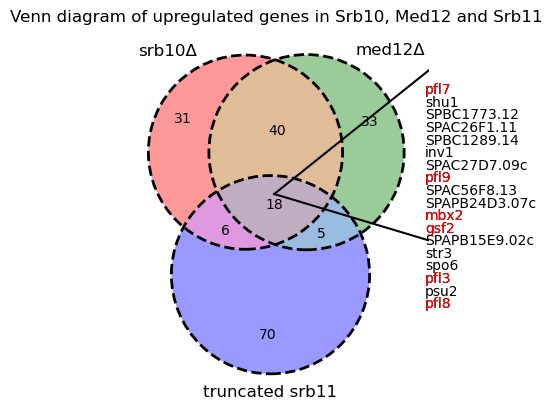

In [16]:
#create a list of top 100 upregulated genes in srb10, med12 and srb11
srb10_up = list(final.sort_values(by=['srb10'],ascending=False)['gene'].head(100))
med12_up = list(final.sort_values(by=['med12'],ascending=False)['gene'].head(100))
#srb11 up is log2fc > 1 and p < 0.05
srb11_up = list(final[(final['log2fc'] > 0) & (final['pval'] < 0.05)].sort_values(by=['log2fc'],ascending=False)['gene'].head(100))

#print genes in intersection of all three lists
print(set(srb10_up).intersection(set(med12_up)).intersection(set(srb11_up)))
shared = set(srb10_up).intersection(set(med12_up)).intersection(set(srb11_up))
#turn this set into a list
shared = list(shared)

#make a venn diagram of the three lists

from matplotlib_venn import venn3_circles, venn3
venn3([set(srb10_up), set(med12_up), set(srb11_up)], set_labels = ('srb10Δ', 'med12Δ', 'truncated srb11'))
venn3_circles([set(srb10_up), set(med12_up), set(srb11_up)], linestyle='dashed')
plt.title('Venn diagram of upregulated genes in Srb10, Med12 and Srb11')
#print strings of gene names in the intersection of the plot
for i,j in enumerate(shared):
    #put it on the plot
      plt.text(0.6,0.4-i*0.05,j,fontsize=10)
      #if it has pfl of gsf or mbx in name then print with red
      if 'pfl' in j or 'gsf' in j or 'mbx' in j:
              plt.text(0.6,0.4-i*0.05,j,fontsize=10,color='red')
#draw lines expanding the middle intersection
plt.plot([0,2],[0,1.6],color='black')
plt.plot([0,2],[0,-0.6],color='black')


plt.show()



{'mcp7', 'SPBPJ4664.02'}


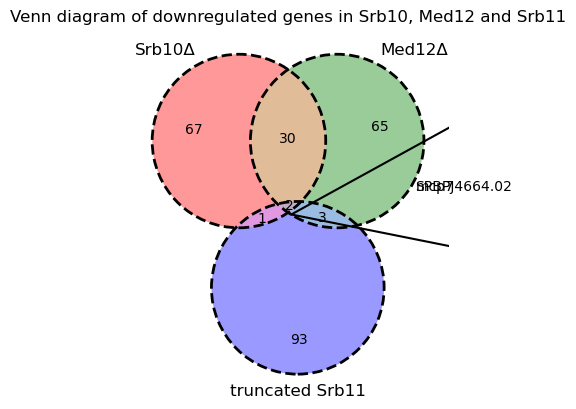

In [17]:
#same with downregulated
srb10_down = list(final.sort_values(by=['srb10'],ascending=True)['gene'].head(100))
med12_down = list(final.sort_values(by=['med12'],ascending=True)['gene'].head(100))
srb11_down = list(final[(final['log2fc'] < 0) & (final['pval'] < 0.05)].sort_values(by=['log2fc'],ascending=True)['gene'].head(100))

print(set(srb10_down).intersection(set(med12_down)).intersection(set(srb11_down)))
shared = set(srb10_down).intersection(set(med12_down)).intersection(set(srb11_down))
shared = list(shared)

from matplotlib_venn import venn3_circles, venn3
venn3([set(srb10_down), set(med12_down), set(srb11_down)], set_labels = ('Srb10Δ', 'Med12Δ', 'truncated Srb11'))
venn3_circles([set(srb10_down), set(med12_down), set(srb11_down)], linestyle='dashed')
plt.title('Venn diagram of downregulated genes in Srb10, Med12 and Srb11')
for i,j in enumerate(shared):
      plt.text(0.5,0,j,fontsize=10)
plt.plot([0,2],[-0.1,1],color='black')
plt.plot([0,2],[-0.1,-0.5],color='black')
plt.show()

In [18]:
#measure correlation between srb10 and med12 and print p value
from scipy.stats import pearsonr
corr, p = pearsonr(final['srb10'], final['med12'])
#print p value with scientific notation
print('p value: {:.2e}'.format(p))
#now same with log2fc	and med12 and srb10
corr, p = pearsonr(final['log2fc'], final['med12'])
print('p value: {:.2e}'.format(p))
corr, p = pearsonr(final['log2fc'], final['srb10'])
print('p value: {:.2e}'.format(p))


p value: 0.00e+00
p value: 1.12e-41
p value: 2.96e-29


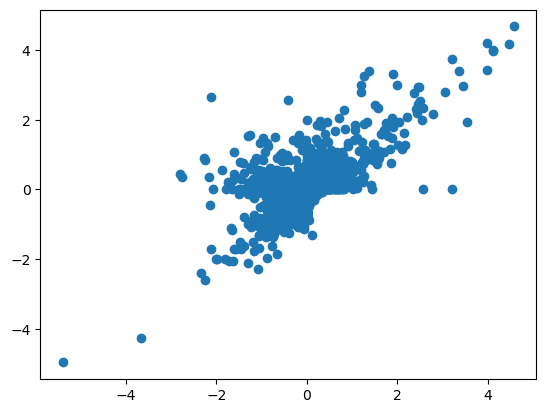

In [19]:
#make scatter plot of srb10 vs med12
plt.scatter(final['srb10'], final['med12'])

{'pfl7', 'shu1', 'SPBC1773.12', 'SPAC26F1.11', 'SPBC1289.14', 'inv1', 'SPAC27D7.09c', 'pfl9', 'SPAC56F8.13', 'SPAPB24D3.07c', 'mbx2', 'gsf2', 'SPAPB15E9.02c', 'str3', 'spo6', 'pfl3', 'psu2', 'pfl8'}


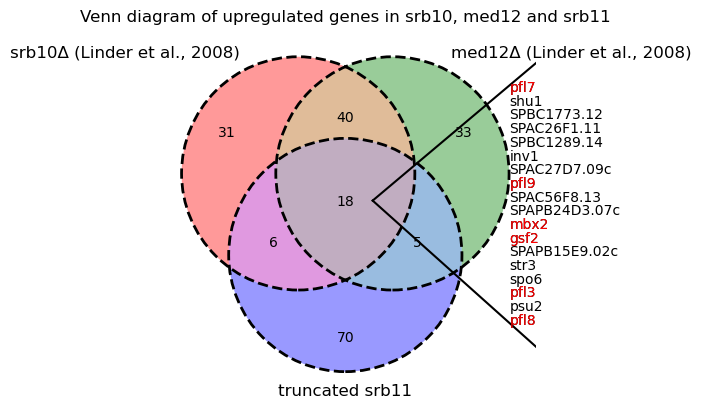

In [20]:
#create a list of top 100 upregulated genes in srb10, med12 and srb11
srb10_up = list(final.sort_values(by=['srb10'],ascending=False)['gene'].head(100))
med12_up = list(final.sort_values(by=['med12'],ascending=False)['gene'].head(100))
#srb11 up is log2fc > 1 and p < 0.05
srb11_up = list(final[(final['log2fc'] > 0) & (final['pval'] < 0.05)].sort_values(by=['log2fc'],ascending=False)['gene'].head(100))

#print genes in intersection of all three lists
print(set(srb10_up).intersection(set(med12_up)).intersection(set(srb11_up)))
shared = set(srb10_up).intersection(set(med12_up)).intersection(set(srb11_up))
#turn this set into a list
shared = list(shared)
shared_saved = shared.copy()
#make a venn diagram of the three lists

from matplotlib_venn import venn3_circles, venn3, venn3_unweighted
venn3_unweighted([set(srb10_up), set(med12_up), set(srb11_up)], set_labels = ('srb10Δ (Linder et al., 2008)', 'med12Δ (Linder et al., 2008)', 'truncated srb11'))
venn3_circles((1,1,1,1,1,1,1), linestyle='dashed')
plt.title('Venn diagram of upregulated genes in srb10, med12 and srb11')
#print strings of gene names in the intersection of the plot
for i,j in enumerate(shared):
    #put it on the plot
      plt.text(0.6,0.4-i*0.05,j,fontsize=10)
      #if it has pfl of gsf or mbx in name then print with red
      if 'pfl' in j or 'gsf' in j or 'mbx' in j:
              plt.text(0.6,0.4-i*0.05,j,fontsize=10,color='red')
#draw lines expanding the middle intersection
plt.plot([0.1,2],[0,1.6],color='black')
plt.plot([0.1,2],[0,-1.7],color='black')


plt.show()


pfl9
shu1
str3
pfl8
SPAC26F1.11
SPAC27D7.09c
SPAC27D7.09c
SPAC56F8.13
SPAPB15E9.02c
SPAPB24D3.07c
SPBC1289.14
SPBC1773.12
spo6
psu2
mbx2
pfl7
pfl3
gsf2
inv1


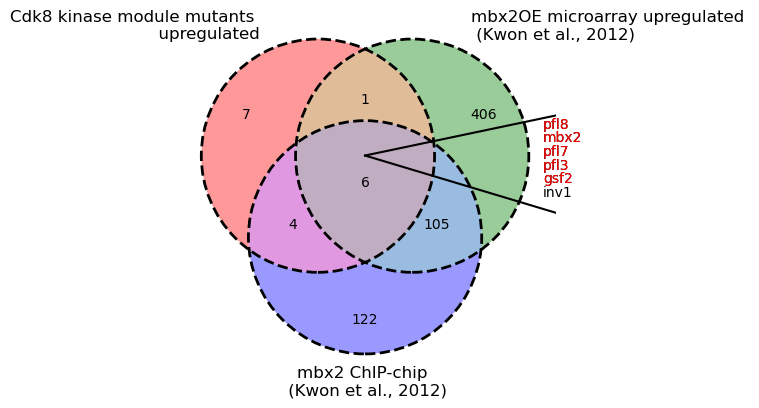

In [21]:
#load mbx2 data from kwon /Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/external data/Kwon et al. 2012/pgen.1003104.s003.xlsx
mbx2 = pd.read_excel('/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/external data/Kwon et al. 2012/pgen.1003104.s003.xlsx',  header=1)
#find shared_saved genes in final and output the systematic name for thgose rows in a list
#add bonferroni correction to p values
mbx2["bonferroni"]=mbx2["mbx2OE p-value"]*len(mbx2["mbx2OE p-value"])
systematics = []
for i in final['gene']:
      if i in shared_saved:
            print(i)
            systematics.append(final[final['gene'] == i]['systematic'].values[0])

#load mbx2_chipseq /Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/external data/Kwon et al. 2012/pgen.1003104.s004.xlsx
mbx2_chipseq = pd.read_excel('/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/external data/Kwon et al. 2012/pgen.1003104.s004.xlsx',  header=1)
#find shared_saved genes in final and output the systematic name for thgose rows in a list
#add bonferroni correction to p values

#take the list of mbx2 Systematic Names where mbx2OE Log2 Fold Change >1 and mbx2OE p-value < 0.0001
mbx2_hits = list(mbx2[(mbx2['mbx2OE Log2 Fold Change'] > 1) & (mbx2['bonferroni'] < 5*10**-2)]['Systematic Name']) 
mbx2_hits_chip = mbx2_chipseq['Systematic Name']
#create venn2 of systematics and mbx2_hits and their overlap
#import venn2
from matplotlib_venn import venn3_circles
#set figsize
overlap = set(systematics).intersection(set(mbx2_hits)).intersection(set(mbx2_hits_chip))
#map overlap back to genes in final
overlap = final[final['systematic'].isin(overlap)]['gene']
#show the two sets and their overlap
#size of circles not proportional but same

venn3_unweighted([set(systematics), set(mbx2_hits_chip),set(mbx2_hits), ], set_labels = ('Cdk8 kinase module mutants \n  upregulated', 'mbx2OE microarray upregulated \n (Kwon et al., 2012)', 'mbx2 ChIP-chip \n (Kwon et al., 2012)'))
venn3_circles((1,1,1,1,1,1,1), linestyle='dashed')
#print strings of gene names in the intersection of the plot
for i,j in enumerate(overlap):
    #put it on the plot
      plt.text(0.65,0.2-i*0.05,j,fontsize=10)
      #if it has pfl of gsf or mbx in name then print with red
      if 'pfl' in j or 'gsf' in j or 'mbx' in j:
              plt.text(0.65,0.2-i*0.05,j,fontsize=10,color='red')
#draw lines expanding the middle intersection
plt.plot([0,2],[0.1,0.52],color='black')
plt.plot([0,2],[0.1,-0.5],color='black')
plt.show()


In [22]:
#intersection of mbx2_hits and systematics
overlap = set(mbx2_hits).intersection(set(systematics_chip))
overlap

NameError: name 'systematics_chip' is not defined

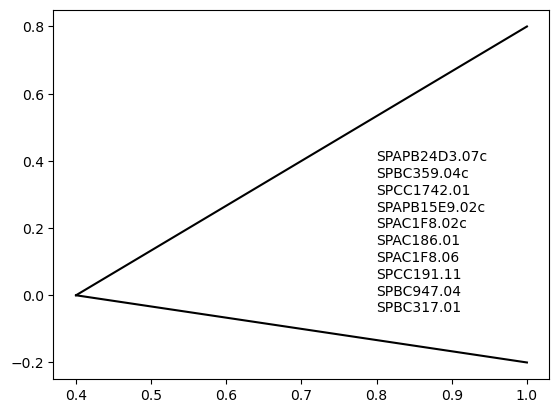

In [ ]:
#print strings of gene names in the intersection of the plot
for i,j in enumerate(overlap):
    #put it on the plot
      plt.text(0.8,0.4-i*0.05,j,fontsize=10)
      #if it has pfl of gsf or mbx in name then print with red
      if 'pfl' in j or 'gsf' in j or 'mbx' in j:
              plt.text(0.8,0.4-i*0.05,j,fontsize=10,color='red')
#draw lines expanding the middle intersection
plt.plot([0.4,1],[0,0.8],color='black')
plt.plot([0.4,1],[0,-0.2],color='black')

In [ ]:
overlap

{'SPAC186.01',
 'SPAC1F8.02c',
 'SPAC1F8.06',
 'SPAPB15E9.02c',
 'SPAPB24D3.07c',
 'SPBC317.01',
 'SPBC359.04c',
 'SPBC947.04',
 'SPCC1742.01',
 'SPCC191.11'}

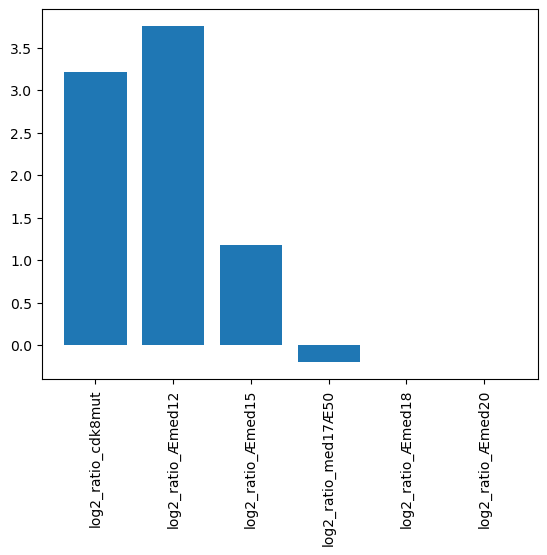

In [ ]:
#full data keep Gene_Symbol column and the columns starting with log2

full_data = full_data[['Gene_Symbol'] + [col for col in full_data.columns if col.startswith('log2')]]
#plot the values for gene_symbol = SPBC317.01t
plt.bar(full_data.columns[1:], full_data[full_data['Gene_Symbol'] == 'SPBC317.01'].values[0][1:])
plt.xticks(rotation=90)
plt.show()


In [ ]:
#create a list of top 100 upregulated genes in srb10, med12 and srb11
srb10_up = list(final.sort_values(by=['srb10'],ascending=False)['systematic'].head(250))
med12_up = list(final.sort_values(by=['med12'],ascending=False)['systematic'].head(250))
#srb11 up is log2fc > 1 and p < 0.05
srb11_up = list(final[(final['log2fc'] > 0) & (final['pval'] < 0.1)].sort_values(by=['log2fc'],ascending=False)['systematic'].head(250))

#print genes in intersection of all three lists
print(set(srb10_up).intersection(set(med12_up)).intersection(set(srb11_up)))
shared = set(srb10_up).intersection(set(med12_up)).intersection(set(srb11_up))
#turn this set into a list
shared = list(shared)

{'SPBC359.01', 'SPBC1289.14', 'SPBC3E7.02c', 'SPBC1778.04', 'SPAC1F8.04c', 'SPAC27D7.09c', 'SPBC19C7.04c', 'SPAC22F3.02', 'SPAC186.01', 'SPCC191.01', 'SPBP23A10.12', 'SPBC16E9.16c', 'SPBC317.01', 'SPCC1281.04', 'SPBPB21E7.01c', 'SPCC1620.04c', 'SPAC23H3.15c', 'SPAPB15E9.02c', 'SPAC1F8.02c', 'SPBC776.16', 'SPCC132.04c', 'SPAC3G6.07', 'SPAC1F8.03c', 'SPBC1773.12', 'SPAC26F1.11', 'SPAPB24D3.07c', 'SPBC359.04c', 'SPAC1F8.05', 'SPAPB8E5.10', 'SPBC1105.13c', 'SPAC1751.01c', 'SPBC2G2.17c', 'SPAC56F8.13', 'SPBC947.04', 'SPACUNK4.17', 'SPAC139.05', 'SPBC1773.06c', 'SPAC25H1.09', 'SPAC5D6.09c', 'SPCC1742.01', 'SPCC1223.12c', 'SPAC1F8.06', 'SPAC56F8.12', 'SPCC191.11', 'SPAC4H3.08'}


In [ ]:
len(srb11_up)

100

In [ ]:
#export as cdk8_angeli
cdk8_angeli = pd.DataFrame(shared)
cdk8_angeli.to_csv('/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/Bence folder/Angeli/cdk8_angeli.txt', index=False, header=False)
#export genes that are found in final systematic
final_sys = final['systematic']
final_sys.to_csv('/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/Bence folder/Angeli/cdk8_background.txt', index=False, header=False)


# Look for genes upregulated in srb10 and 11 but not in med12

In [ ]:
#create a list of top 100 upregulated genes in srb10, med12 and srb11
srb10_up = list(final.sort_values(by=['srb10'],ascending=False)['gene'].head(500))
med12_up = list(final.sort_values(by=['med12'],ascending=False)['gene'].head(500))
#srb11 up is log2fc > 1 and p < 0.05
srb11_up = list(final[(final['log2fc'] > 0) & (final['pval'] < 0.05)].sort_values(by=['log2fc'],ascending=False)['gene'].head(500))


In [ ]:
#find gene that is in srb10_up and srb11_up but not in med12_up
genes = []
for i in srb10_up:
      if i in srb11_up and i not in med12_up:
            genes.append(i)
genes

['SPAC56F8.15',
 'SPCC794.04c',
 'pdc202',
 'mug155',
 'ish1',
 'spn6',
 'mug35',
 'hsp3101',
 'SPAC2F3.05c',
 'SPCC576.19c',
 'pfl5',
 'sut1',
 'SPCC16A11.15c',
 'ppk33',
 'SPAC637.03',
 'git5',
 'meu7',
 'mug126',
 'msw1',
 'otg2',
 'the4',
 'ksp1',
 'SPBC1271.07c',
 'SPBC8E4.05c',
 'SPCC70.10',
 'psf3',
 'ctt1',
 'SPAC16E8.05c',
 'dys1',
 'mug98',
 'SPCC1884.01',
 'ntp1',
 'SPCC1183.02',
 'tgd1']